In [1]:
!pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download shubhamgoel27/dermnet

 99% 1.71G/1.72G [00:07<00:00, 254MB/s]
100% 1.72G/1.72G [00:07<00:00, 236MB/s]


In [ ]:
!unzip /content/dermnet.zip -d /content/

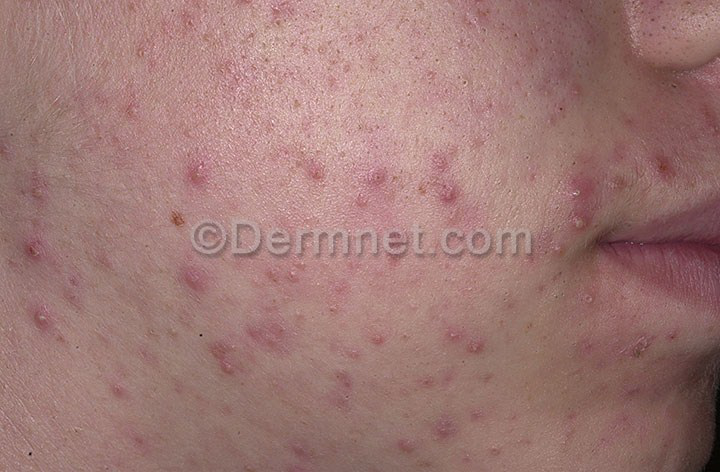

In [7]:
from PIL import Image
im = Image.open('/content/train/Acne and Rosacea Photos/07Acne081101.jpg')
 
im

In [14]:
import numpy as np 
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [15]:
IMAGE_SIZE = (256,256)
TRAIN_DIR = '/content/train'
TEST_DIR = '/content/test'

In [16]:
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)


In [29]:
training_set = train_datagen.flow_from_directory(TRAIN_DIR,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

Found 5113 images belonging to 9 classes.


In [30]:
test_set = test_datagen.flow_from_directory(TEST_DIR,
                                            target_size = IMAGE_SIZE,
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 1384 images belonging to 9 classes.


In [31]:
base_model = tf.keras.applications.VGG19(
    include_top=False, weights='imagenet'
    ,input_shape = (256,256,3) 
)

In [32]:
base_model.trainable = False

In [39]:
inputs = tf.keras.Input(shape = (256,256,3))
x = base_model(inputs,training = False)
x = tf.keras.layers.Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(512,activation = 'relu')(x)
x = Dense(512,activation = 'relu')(x)
output = Dense(9, activation='softmax')(x)
# define new model
model = Model(inputs=inputs, outputs=output)
# summarize
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_10 (Dense)            (None, 1024)              33555456  
                                                                 
 dense_11 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               5248

In [40]:
ACCURACY_THRESHOLD = 0.95

In [41]:
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):   
          print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
          self.model.stop_training = True

In [42]:
callbacks = myCallback()

In [43]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(training_set, validation_data=test_set, epochs=40, batch_size=64,callbacks=[callbacks])

In [45]:
!wget /content/ https://image.shutterstock.com/image-photo/asian-woman-acne-on-face-260nw-1033648339.jpg

/content/: Scheme missing.
--2022-05-09 12:02:09--  https://image.shutterstock.com/image-photo/asian-woman-acne-on-face-260nw-1033648339.jpg
Resolving image.shutterstock.com (image.shutterstock.com)... 13.249.80.103, 13.249.80.70, 13.249.80.25, ...
Connecting to image.shutterstock.com (image.shutterstock.com)|13.249.80.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23603 (23K) [image/jpeg]
Saving to: ‘asian-woman-acne-on-face-260nw-1033648339.jpg’

asian-woman-acne-on 100%[===================>]  23.05K  --.-KB/s    in 0.001s  

2022-05-09 12:02:09 (19.6 MB/s) - ‘asian-woman-acne-on-face-260nw-1033648339.jpg’ saved [23603/23603]

FINISHED --2022-05-09 12:02:09--
Total wall clock time: 0.3s
Downloaded: 1 files, 23K in 0.001s (19.6 MB/s)


In [46]:
from google.colab.patches import cv2_imshow
cv3_imshow('/content/asian-woman-acne-on-face-260nw-1033648339.jpg')

NameError: ignored

In [48]:
import cv2
def findDisease(path):
  # Read the input image
  img = cv2.imread(path)
  
  # Convert into grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  # Load the cascade
  face_cascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_alt2.xml')
  
  # Detect faces
  faces = face_cascade.detectMultiScale(gray, 1.1, 4)
  
  # Draw rectangle around the faces and crop the faces
  for (x, y, w, h) in faces:
      cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
      faces = img[y:y + h, x:x + w]
      cv2_imshow(img)
      cv2.imwrite('face.jpg', faces)
      
  # Display the output
  cv2.imwrite('detcted.jpg', img)
  cv2_imshow(faces)
  cv2.waitKey()
  f = cv2.imread('/content/face.jpg')
  b=f.resize((1,256,256,3),refcheck=False)
  pred=model.predict(f)
  return pred


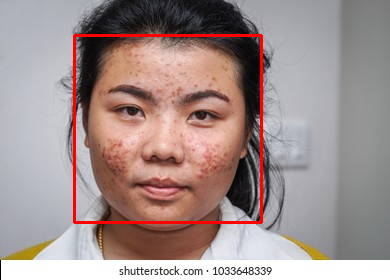

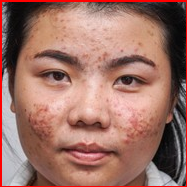

In [50]:
result = findDisease('/content/asian-woman-acne-on-face-260nw-1033648339.jpg')

In [51]:
print(result)

[[0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 7.3202483e-34 0.0000000e+00]]


In [58]:
predict_class = np.argmax(result, axis=1)

In [59]:
print(predict_class)

[2]
